In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class AbstractParamODETarget:
    def __init__(self, dt=1e-3, t_step=0.1, dim=2, param_dim=2):
        """
        Initializes an instance of the class.

        Parameters:
        - dt (float): The time step size for the inner loop to compute the value at each outer time step t_step.
        - t_step (float): The outer time step.
        - dim (int): The dimension of the system state.
        - param_dim (int): The dimension of the parameters.

        Returns:
        None
        """
        self.dt = dt
        self.t_step = t_step
        self.n_step = int(t_step / dt)
        self.dim = dim
        self.param_dim = param_dim

    def rhs(self, x, param):
        """
        Right-hand side of the ODE to be implemented by subclasses.

        :param x: state variable
        :param param: parameters for the ODE
        :return: the time derivative of x
        """
        raise NotImplementedError("Subclasses should implement this method.")

    def euler(self, x, param):
        """
        ODE Solver using Euler's method.

        :param x: state variable
        :param param: parameters for the ODE
        :return: ODE Solution at t_step after iterating the Euler method n_step times
        """
        for _ in range(self.n_step):
            x = x + self.dt * self.rhs(x, param)
        return x

    def generate_init_data(self, n_traj, traj_len, x_min, x_max, param_min, param_max, seed_x=11, seed_param=22):
        """
        Generate initial data for the ODE system. 
        In this case, the initial data is generated randomly. 
        The corresponding parameters are the same on each trajectory. But for different trajectories, the parameters are different.

        Parameters:
        - n_traj (int): Number of trajectories to generate.
        - traj_len (int): Length of each trajectory.
        - x_min, x_max (float): Range for the initial state.
        - param_min, param_max (float): Range for the parameters.
        - seed_x (int): Seed for random number generator for generating initial states.
        - seed_param (int): Seed for random number generator for generating parameters.

        Returns:
        - data_x (ndarray): Array of shape (n_traj * traj_len, self.dim) containing the generated initial states.
        - param (ndarray): Array of shape (n_traj * traj_len, self.param_dim) containing the generated parameters.
        """
        np.random.seed(seed_x)
        x0 = np.random.uniform(low=x_min, high=x_max, size=(n_traj, self.dim))

        np.random.seed(seed_param)
        param = np.random.uniform(low=param_min, high=param_max, size=(n_traj, self.param_dim))

        data_x = [x0]
        for t in range(traj_len - 1):
            data_x.append(self.euler(data_x[t], param))

        # Reshape and transpose data_x for the correct format
        data_x = np.array(data_x).reshape(n_traj * traj_len, self.dim)

        # Repeat parameters for each trajectory length
        repeats_constant = traj_len * np.ones(shape=(n_traj,), dtype="int32")
        param = np.repeat(param, repeats=repeats_constant, axis=0)

        return np.asarray(data_x), np.asarray(param)

    def generate_next_data(self, data_x, param):
        """
        Generate the next state using the Euler solver.

        Parameters:
        - data_x (ndarray): The current state of the system.
        - param (ndarray): Parameters of the ODE.

        Returns:
        - data_y (ndarray): The next state of the system after applying Euler's method.
        """
        data_y = self.euler(data_x, param)
        return data_y


In [3]:
class VanderPolMathieuTarget(AbstractParamODETarget):
    def __init__(self, mu=1, dt=1e-3, t_step=1e-2, dim=2, param_dim=1, k1=2, k2=2, k3=2, k4=1, w0=1):
        """
        Initializes the VanderPolMathieuTarget system.

        Parameters:
        - mu (float): Van der Pol oscillator parameter.
        - dt (float): Time step size for the inner loop.
        - t_step (float): Time step for the outer loop.
        - dim (int): Dimension of the state.
        - param_dim (int): Dimension of the parameters.
        - k1, k2, k3, k4, w0 (float): System parameters for the Van der Pol-Mathieu equation.

        """
        super().__init__(dt, t_step, dim, param_dim)
        self.x_min = -1
        self.x_max = 1
        self.u_min = -1
        self.u_max = 1
        self.mu = mu
        self.k1 = k1
        self.k2 = k2
        self.k3 = self.mu
        self.k4 = k4
        self.w0 = w0

    def rhs(self, data_x, param):
        """
        Compute the right-hand side of the Van der Pol-Mathieu system.

        Parameters:
        - data_x (ndarray): The current state of the system (shape: [n_traj, dim]).
        - param (ndarray): The system parameters (shape: [n_traj, param_dim]).

        Returns:
        - ndarray: The time derivative of the system state (shape: [n_traj, dim]).
        """
        x1 = np.reshape(data_x[:, 0], newshape=(data_x.shape[0], 1))
        x2 = np.reshape(data_x[:, 1], newshape=(data_x.shape[0], 1))
        param = np.reshape(param, newshape=(data_x.shape[0], 1))  # Ensure param is correctly reshaped

        f1 = x2
        f2 = (
            (self.k1 - self.k2 * x1**2) * x2
            - (self.w0**2 + 2 * self.k3 * param**2 - self.k3) * x1
            + self.k4 * param
        )
        return np.concatenate([f1, f2], axis=-1)

    def generate_init_data(self, n_traj, traj_len, seed_x=11, seed_param=22):
        """
        Generate initial data for the Van der Pol-Mathieu system.
        In this case, the initial data is generated randomly. 
        The corresponding parameter inputs (controls) are randomly generates at each time steps on each trajectory. For different trajectories, the parameters are different.

        Parameters:
        - n_traj (int): Number of trajectories.
        - traj_len (int): Length of each trajectory.
        - seed_x (int): Random seed for generating initial state.
        - seed_param (int): Random seed for generating parameters.

        Returns:
        - data_x (ndarray): Generated state data of shape (n_traj * traj_len, dim).
        - param (ndarray): Generated parameters of shape (n_traj * traj_len, param_dim).
        """
        data_x = []

        # Generate random initial states
        np.random.seed(seed_x)
        x0 = np.random.uniform(low=self.x_min, high=self.x_max, size=(n_traj, self.dim))

        # Generate random parameters
        np.random.seed(seed_param)
        param = np.random.uniform(low=self.u_min, high=self.u_max, size=(traj_len, n_traj, self.param_dim))

        # Euler integration for the trajectories
        data_x.append(x0)
        for t in range(traj_len - 1):
            x_next = self.euler(data_x[-1], param[t])
            data_x.append(x_next)

        # Reshape data_x and param for correct output format
        data_x = np.array(data_x).reshape(-1, self.dim)
        param = np.array(param).reshape(-1, self.param_dim)

        return data_x, param


In [4]:
target_dim = 2
param_dim = 1

# fixed parameters in VanderPolMathieuTarget
k1=2
k2=2
k3=2
k4=1
w0=1

In [5]:
# parameter for strong non-linearity
# As mu increases, the system becomes more non-linear
mu = 1

In [6]:
n_traj = 1000
traj_len = 50

In [34]:
vdp_mathieu = VanderPolMathieuTarget(
        mu=mu, dim=target_dim, param_dim=param_dim, k1=k1, k2=k2, k4=k4, w0=w0
    )
data_x, data_u = vdp_mathieu.generate_init_data(
    n_traj=n_traj, traj_len=traj_len, seed_x=625, seed_param=521
)
data_y = vdp_mathieu.generate_next_data(data_x, data_u)

In [35]:
# Reshape data to shape: (n_traj, traj_len, dim)
data_x = data_x.reshape(traj_len, n_traj, target_dim).transpose(1, 0, 2)
data_u = data_u.reshape(traj_len, n_traj, param_dim).transpose(1, 0, 2)
data_y = data_y.reshape(traj_len, n_traj, target_dim).transpose(1, 0, 2)

In [36]:
data_x.shape

(1000, 50, 2)

Text(0, 0.5, '$x_2$')

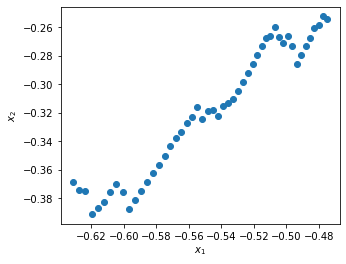

In [41]:
# Plot one trajectory
plt.figure(figsize=(5, 4))
plt.plot(data_x[0, :, 0], data_x[0, :, 1], "o")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")